# Dataset

The data used in this notebook comes from the Kaggle's Electric Power Consumption dataset. This dataset is a CSV file with 3 columns of electric power consumption recorded at a frequency of 6 samples per hour (1 sample every 10 minutes). Each of these 3 columns represents a zone of the city of Tétouan, in Morocco.

**Features:**

Date Time: Time window of ten minutes.
Temperature: Weather Temperature.
Humidity: Weather Humidity.
Wind Speed: Wind Speed.
General Diffuse Flows: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
Diffuse Flows
Target:

* Zone 1 Power Consumption
* Zone 2 Power Consumption
* Zone 3 Power Consumption

In [1]:
# Import packages and modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
#from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import r2_score
import matplotlib.dates as mdates 

In [2]:
# Load Dataset
df  = pd.read_csv("/kaggle/input/electric-power-consumption/powerconsumption.csv")

df.describe()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


In [3]:
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [4]:
df.tail()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504
52415,12/30/2017 23:50,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820


In [5]:
# sns.pairplot(df[['Temperature', 'Humidity', 'WindSpeed','GeneralDiffuseFlows','DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
# plt.show()

In [6]:
# # Time series plot for PowerConsumption
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='Datetime', y='PowerConsumption_Zone1', data=df, label='Zone 1')
# # Format x-axis to show only the year
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display only the year

# plt.xlabel('Year')
# plt.ylabel('Power Consumption')
# plt.title('Power Consumption Over Time')
# plt.show()

# Chronological Order and Equidistant Timestamps

In [7]:
df['Datetime']=pd.to_datetime(df.Datetime)
df.sort_values(by='Datetime', ascending=True, inplace=True)

chronological_order = df['Datetime'].is_monotonic_increasing

time_diffs = df['Datetime'].diff()
equidistant_timestamps = time_diffs.nunique() == 1
chronological_order, equidistant_timestamps


(True, True)

In [8]:
df.tail()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
52411,2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504
52415,2017-12-30 23:50:00,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820


# Handle Missing

In [9]:
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

# Feature engineering

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.month
    df['year'] = df.index.year
    df['season'] = df['month'] % 12 // 3 + 1
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Additional features
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = (df['dayofmonth'] == 1).astype(int)
    df['is_month_end'] = (df['dayofmonth'] == df.index.days_in_month).astype(int)
    df['is_quarter_start'] = (df['dayofmonth'] == 1) & (df['month'] % 3 == 1).astype(int)
    df['is_quarter_end'] = (df['dayofmonth'] == df.groupby(['year', 'quarter'])['dayofmonth'].transform('max'))
    
    # Additional features
    df['is_working_day'] = df['dayofweek'].isin([0, 1, 2, 3, 4]).astype(int)
    df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    df['is_peak_hour'] = df['hour'].isin([8, 12, 18]).astype(int)
    
    # Minute-level features
    df['minute_of_day'] = df['hour'] * 60 + df['minute']
    df['minute_of_week'] = (df['dayofweek'] * 24 * 60) + df['minute_of_day']
    
    return df.astype(float)

In [11]:
df = df.set_index('Datetime')
df = create_features(df)
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,hour,minute,...,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_working_day,is_business_hours,is_peak_hour,minute_of_day,minute_of_week
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8640.0
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0.0,10.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,8650.0
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0.0,20.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,20.0,8660.0
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0.0,30.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,30.0,8670.0
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0.0,40.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,40.0,8680.0


# Correlation Analysis

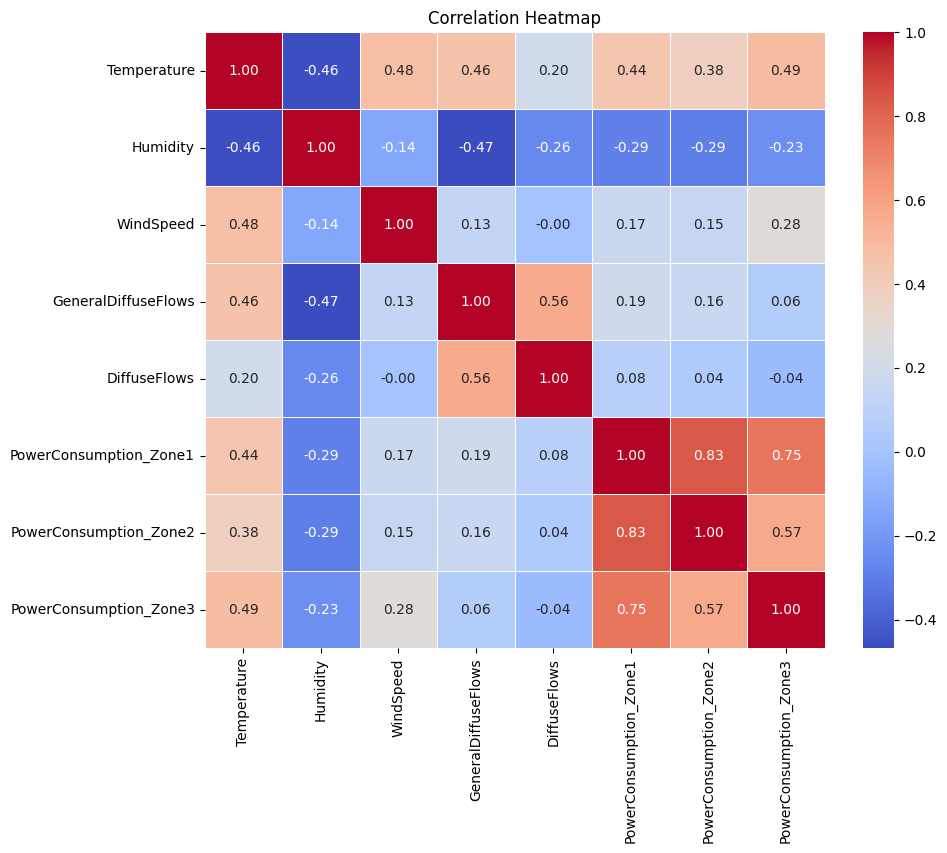

In [12]:
# Calculate correlation matrix
correlation_matrix = df[['Temperature', 'Humidity', 'WindSpeed','GeneralDiffuseFlows','DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


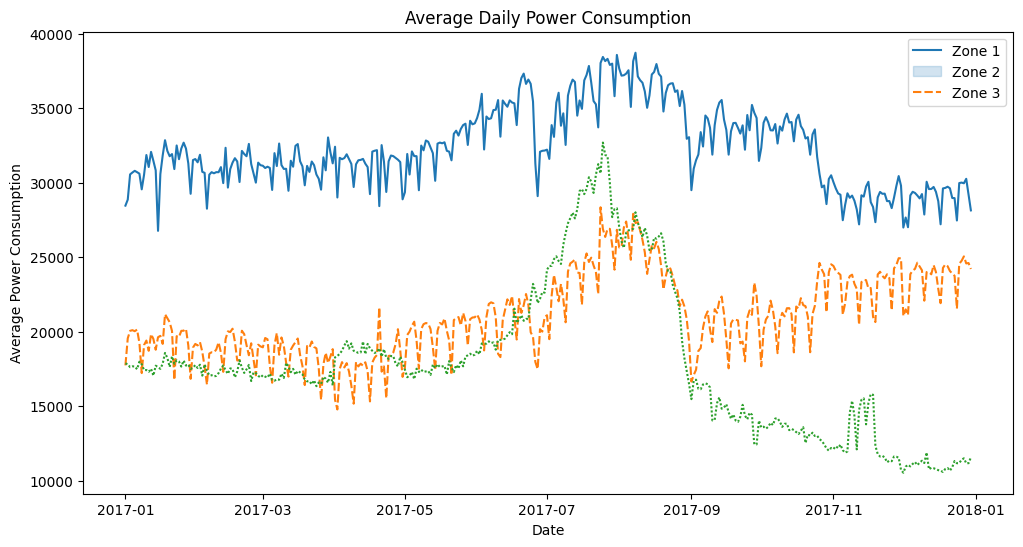

In [13]:
# Resample the data for more meaningful time series analysis (e.g., daily, weekly)
daily_resampled = df.resample('D').mean()

# Plot daily Power Consumption for each zone
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_resampled[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.xlabel('Date')
plt.ylabel('Average Power Consumption')
plt.title('Average Daily Power Consumption')
plt.legend(labels=['Zone 1', 'Zone 2', 'Zone 3'])
plt.show()

# Train and evaluation

In [14]:
from sklearn.preprocessing import StandardScaler

# Separate the input features (X) and target variables (y)
X = df.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1)
y = df[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']]

# Initialize StandardScaler for y
scaler_y = StandardScaler()

# Fit and transform  y
y_scaled = scaler_y.fit_transform(y)

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.25, shuffle=False)

# XGBOOST MODEL

In [16]:
# # Define the hyperparameter grid for XGBoost
# param_grid = {
#     'objective':['reg:squarederror'],
#     'max_depth': [2, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [0.5, 0.7],
#     'n_estimators': [1000,1500,2000],
#     'min_child_weight': [1, 2],
#     'booster':['gbtree']
# }

# # Create the XGBoost model object
# xgb_model = xgb.XGBRegressor(tree_method='gpu_hist')


# # Create the GridSearchCV 
# grid_search = GridSearchCV(xgb_model, param_grid, cv=7, scoring='neg_mean_squared_error')

# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # Print the best set of hyperparameters and the corresponding score
# print("Best set of hyperparameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

# # Evaluate the model on the test set
# y_pred = grid_search.best_estimator_.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# print("Mean squared error on test set: ", mse)
# print("Mean absolute error on test set: ", mae)

In [17]:
# model =  grid_search.best_estimator_
# xgboost_history = model.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
#        verbose=200)


In [18]:
# # Lets predict with the model
# train_predict = model.predict(X_train)
# test_predict = model.predict(X_test)


# mse = mean_squared_error(y_test, test_predict)
# mae = mean_absolute_error(y_test, test_predict)
# print("Mean squared error on test set: ", mse)
# print("Mean absolute error on test set: ", mae)

In [19]:
# # Feature Importances
# _ = plot_importance(model, height=0.9)

#  Time series Transformers

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming your existing data preparation code is here
# ...

# Convert data to sequences for Transformer
def create_sequences(data, targets, look_back=24*60, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data) - look_back - forecast_horizon):
        X.append(data[i:(i + look_back)])
        y.append(targets[i + look_back:i + look_back + forecast_horizon])
    return np.array(X), np.array(y)

# Scale features and targets
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [21]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

batch_size= 32

# Create sequences
look_back = 24 * 60  # 24 hours of minute-level data
forecast_horizon = 1  # Predict next time step
X_seq, y_seq = create_sequences(X_scaled, y_scaled, look_back, forecast_horizon)
# Train-test split (maintain temporal order)
test_size = int(0.25 * len(X_seq))
X_train, X_test = X_seq[:-test_size], X_seq[-test_size:]
y_train, y_test = y_seq[:-test_size], y_seq[-test_size:]
#for testing

# train_indices = np.random.choice(len(X_train), batch_size, replace=False)
# test_indices = np.random.choice(len(X_test), batch_size, replace=False)

# X_train = X_train[train_indices]
# y_train = y_train[train_indices]

# X_test = X_test[test_indices]
# y_test = y_test[test_indices]

print("Train_len ", X_train.shape)
print("Test_len ", X_test.shape)

Train_len  (38232, 1440, 26)
Test_len  (12743, 1440, 26)


In [22]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Len train ", len(train_loader))
print("Len test ", len(test_loader))

# Transformer Model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=128, nhead=8, num_layers=3, dropout=0.1):
        super().__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.decoder = nn.Linear(d_model, output_dim)
        
    def forward(self, src):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer(src, src)  # Using src as both encoder and decoder input
        return self.decoder(output[:, -1, :])  # Take last time step's output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]
        return self.dropout(x)

Len train  1195
Len test  399


In [23]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
# Make sure to import any other required modules and define your TimeSeriesTransformer

# Initialize model
input_dim = X_train.shape[2]  # Number of features
output_dim = y_train.shape[2]  # Number of targets
model = TimeSeriesTransformer(input_dim, output_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

# Training parameters
num_epochs = 15  # Set the total number of epochs you want to run
best_val_loss = float('inf')
patience = 10
patience_counter = 0

# Check if a checkpoint exists and load it if available
checkpoint_path = 'checkpoint.pth'
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # resume from the next epoch
    best_val_loss = checkpoint['best_val_loss']
    patience_counter = checkpoint['patience_counter']
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("No checkpoint found, starting training from scratch.")

# Training loop
for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0
    batch_in = 0
    import time
    st_time = time.time()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        # Adjust squeeze as needed (here assuming batch_y is shaped [batch, 1, ...])
        loss = criterion(outputs, batch_y.squeeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        batch_in += 1
        if batch_in % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch_in}: Train Loss: {train_loss/batch_in:.4f}')
            #print("train time ", time.time() - st_time)
    # Validation
    model.eval()
    val_loss = 0.0
    batch_in = 0
    st_time = time.time()
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y.squeeze(1)).item()
            batch_in+=1
            # if batch_in % 100 == 0:
            #     print(f'Epoch {epoch+1} Batch {batch_in}: Valid Loss: {val_loss/batch_in:.4f}')
            #     print("valid time ", time.time() - st_time)
            
    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    scheduler.step(val_loss)
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Checkpoint saving and early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break


No checkpoint found, starting training from scratch.
Epoch 1 Batch 100: Train Loss: 1.0418
Epoch 1 Batch 200: Train Loss: 0.6939
Epoch 1 Batch 300: Train Loss: 0.5190
Epoch 1 Batch 400: Train Loss: 0.4196
Epoch 1 Batch 500: Train Loss: 0.3561
Epoch 1 Batch 600: Train Loss: 0.3114
Epoch 1 Batch 700: Train Loss: 0.2786
Epoch 1 Batch 800: Train Loss: 0.2535
Epoch 1 Batch 900: Train Loss: 0.2331
Epoch 1 Batch 1000: Train Loss: 0.2180
Epoch 1 Batch 1100: Train Loss: 0.2049
Epoch 1: Train Loss: 0.1941, Val Loss: 0.3601
Checkpoint saved at epoch 1
Epoch 2 Batch 100: Train Loss: 0.0618
Epoch 2 Batch 200: Train Loss: 0.0567
Epoch 2 Batch 300: Train Loss: 0.0535
Epoch 2 Batch 400: Train Loss: 0.0526
Epoch 2 Batch 500: Train Loss: 0.0522
Epoch 2 Batch 600: Train Loss: 0.0519
Epoch 2 Batch 700: Train Loss: 0.0511
Epoch 2 Batch 800: Train Loss: 0.0510
Epoch 2 Batch 900: Train Loss: 0.0504
Epoch 2 Batch 1000: Train Loss: 0.0499
Epoch 2 Batch 1100: Train Loss: 0.0491
Epoch 2: Train Loss: 0.0486, Val 

In [24]:
# Load best model
checkpoint_path = 'checkpoint.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluation
model.eval()

# Evaluation in batches
y_pred = []

with torch.no_grad():
    for i in range(0, len(X_test_tensor), batch_size):
        # Get batch and move to GPU
        batch = X_test_tensor[i:i+batch_size].to(device)
        
        # Predict and move to CPU
        pred = model(batch).cpu().numpy()
        y_pred.append(pred)
        
        # Free GPU memory
        del batch, pred
        torch.cuda.empty_cache()

# Combine all batches
y_pred = np.concatenate(y_pred, axis=0)

# Inverse transform predictions
# y_pred = scaler_y.inverse_transform(y_pred)
# y_test_actual = scaler_y.inverse_transform(y_train.squeeze(1))

# Calculate metrics
mse = mean_squared_error(y_test.squeeze(1), y_pred)
mae = mean_absolute_error(y_test.squeeze(1), y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

<ipython-input-24-b9568c67c95f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Test MSE: 0.2199
Test MAE: 0.3593


In [25]:
# import shap
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import plot_acf
# explainer = shap.Explainer(model)
# shap_values = explainer(X_test)
# shap.summary_plot(shap_values, X_test, plot_type='bar')

# # Time series challenges
# print("\nStationarity Test (Zone 1):")
# adf_result = adfuller(df[zone])
# print(f"ADF p-value: {adf_result[1]:.4f}")

# plt.figure(figsize=(12,4))
# plot_acf(df[zone], lags=144*7)  # Weekly seasonality check
# plt.title('Autocorrelation Plot')
# plt.show()

# print("\nStandard Deviations:")
# print(df[['Zone 1 Power Consumption', 'Zone 2 Power Consumption', 
#           'Zone 3 Power Consumption']].std())